In [1]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer

import numpy as np
import os
import random
from matplotlib import pyplot as plt
import torchview

from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Disable cuDNN benchmark to ensure deterministic behavior (slightly slower)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

/home/insane/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!mkdir -p models-pdf

In [3]:
def print_recursive(obj, indent=0):
    if isinstance(obj, torch.Tensor):
        print(" " * indent + f"Tensor shape: {obj.shape}")
    elif isinstance(obj, (list, tuple)):
        print(" " * indent + f"{type(obj).__name__}:")
        for item in obj:
            print_recursive(item, indent + 2)
    elif isinstance(obj, dict):
        print(" " * indent + "dict:")
        for key, value in obj.items():
            print(" " * indent + f"  {key}:")
            print_recursive(value, indent + 4)
    else:
        print(" " * indent + str(obj))


In [4]:
# Load the pretrained model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pipeline
pipeline = StableDiffusionPipeline.from_pretrained(model_id).to(device)
pipeline.scheduler.set_timesteps(50)
pipeline.scheduler.temperature = 0
pipeline.safety_checker=lambda images, clip_input: (images, [False] * len(images))

# Extract the model components
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
unet = pipeline.unet
vae = pipeline.vae
scheduler = pipeline.scheduler

print(tokenizer)
print(text_encoder)
print(unet)
print(vae)
print(scheduler)


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.14it/s]


CLIPTokenizer(name_or_path='/home/insane/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (sel

/tmp/ipykernel_442663/2245761794.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (1, unet.in_channels, 512 // 8, 512 // 8)
100%|██████████| 50/50 [00:05<00:00,  9.89it/s]


StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x70CDBC394C20>], nsfw_content_detected=[False])


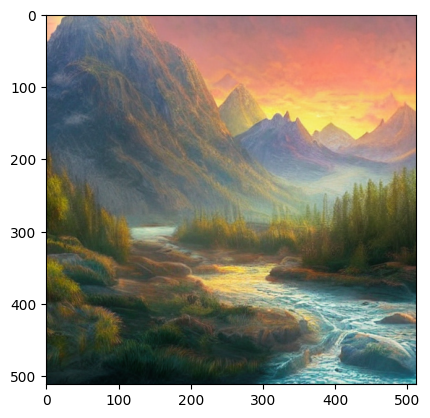

In [5]:
# Define your prompt
prompt = "A fantasy landscape with mountains and a river during sunset"

latents_shape = (1, unet.in_channels, 512 // 8, 512 // 8)

# Generate random noise
latents = torch.randn(latents_shape, generator=torch.manual_seed(seed)).to(device)
latents = latents * scheduler.init_noise_sigma

# Generate image
with torch.no_grad():
    pipeline_result = pipeline(prompt, latents=latents, num_inference_steps=50, generator=torch.manual_seed(seed))

print(pipeline_result)

# Save the image
plt.imshow(pipeline_result.images[0])

# Step by Step

In [5]:
nature_prompts = [
    "A serene mountain valley blanketed in fresh snow.",
    "A tropical beach with clear blue waters and palm trees.",
    "A dense forest with sunlight streaming through the canopy.",
    "A tranquil lake surrounded by tall pine trees.",
    "A wide grassland with a herd of deer grazing peacefully.",
    "A majestic waterfall cascading into a deep, blue pool.",
    "A rocky canyon illuminated by the soft glow of sunrise.",
    "A trail winding through a forest covered in autumn leaves.",
    "A pristine glacier in a polar region under a vivid aurora.",
    "A vast savanna with acacia trees and grazing zebras.",
    "A calm river winding through rolling green hills.",
    "A small wooden cabin nestled in a forest clearing.",
    "A cliff overlooking a roaring ocean during a storm.",
    "A field of golden wheat swaying in the summer breeze.",
    "A misty mountain peak rising above the clouds.",
    "A lush jungle teeming with exotic plants and animals.",
    "A quiet pond with lily pads and a pair of swans gliding.",
    "A windy desert with towering sand dunes.",
    "A vibrant field of lavender stretching to the horizon.",
    "A volcanic crater with steam rising into the air.",
    "A quiet forest glade illuminated by fireflies at night.",
    "A frozen tundra with patches of ice and snow-covered shrubs.",
    "A colorful coral reef bustling with marine life.",
    "A peaceful orchard with rows of blooming fruit trees.",
    "A canyon carved by a winding river over centuries.",
    "A foggy meadow with dew-covered grass in the morning.",
    "A clear mountain stream rushing over smooth rocks.",
    "A herd of wild horses galloping across a grassy plain.",
    "A thunderstorm rolling over a forested valley.",
    "A tranquil bay with small fishing boats anchored near the shore.",
    "A rocky coastline with crashing waves and sea spray.",
    "A meadow filled with daisies and butterflies.",
    "A dense mangrove forest thriving along a river delta.",
    "A highland plateau dotted with small shrubs and boulders.",
    "A frozen lake reflecting the pale light of the moon.",
    "A sunflower field glowing under the summer sun.",
    "A jungle waterfall surrounded by vines and tropical flowers.",
    "A mountain trail overlooking a vast, misty valley.",
    "A vast, untouched wilderness with towering cliffs.",
    "A small village nestled in a lush valley.",
    "A serene mountain lake reflecting the starry night sky.",
    "A wildflower meadow alive with buzzing bees.",
    "A deep cave with glittering stalactites and underground streams.",
    "A golden autumn forest with leaves blanketing the ground.",
    "A windy hilltop overlooking a patchwork of farmland.",
    "A pine forest with a carpet of soft, fallen needles.",
    "A lush oasis in the middle of a barren desert.",
    "A rugged mountain pass covered in ice and snow.",
    "A verdant jungle alive with the sounds of chirping birds.",
    "A peaceful valley cradled between two towering mountain ranges."
]

urban_prompts = [
    "A busy intersection in a city lit by vibrant billboards.",
    "A quiet park in the middle of a bustling downtown area.",
    "A sleek glass skyscraper reflecting the sky and neighboring buildings.",
    "A subway train speeding through an underground tunnel.",
    "A high-tech office building with a minimalist design.",
    "A lively café on a cobblestone street in an old city center.",
    "A sprawling urban plaza surrounded by modern buildings.",
    "A crowded shopping mall filled with people and bright signage.",
    "A rooftop terrace offering panoramic views of the city skyline.",
    "A graffiti-covered wall in a vibrant arts district.",
    "A crowded pedestrian street with street performers entertaining passersby.",
    "A bustling harbor with cargo ships and cranes loading containers.",
    "A serene canal running through a historic urban neighborhood.",
    "A row of modern townhouses with small gardens out front.",
    "A busy airport terminal with passengers rushing to board.",
    "A quiet library with high ceilings and rows of shelves.",
    "A curved bridge illuminated by soft lighting at night.",
    "A sprawling train station with people rushing between platforms.",
    "A vibrant street festival with colorful decorations and music.",
    "A historic theater with an illuminated marquee.",
    "A modern stadium filled with cheering fans.",
    "A glass-covered atrium in a luxury hotel.",
    "A crowded marketplace with colorful goods and lively vendors.",
    "A high-rise apartment building with balconies and floor-to-ceiling windows.",
    "A bike lane winding through a busy urban park.",
    "A neon-lit street in a lively downtown district at night.",
    "A bustling café with outdoor seating on a tree-lined avenue.",
    "A sprawling bridge spanning a river, lined with pedestrian walkways.",
    "A futuristic shopping center with sleek architecture.",
    "A quiet suburban neighborhood with neatly lined houses.",
    "A lively food court in a crowded urban mall.",
    "A towering Ferris wheel on the edge of a modern pier.",
    "A high-speed train station with sleek platforms.",
    "A modern art gallery with abstract sculptures and paintings.",
    "A city square with a large fountain and people relaxing nearby.",
    "A metro station with minimalist design and artistic lighting.",
    "A trendy rooftop bar overlooking a busy city street.",
    "A vibrant market square with small artisan stalls.",
    "A bustling harborfront with luxury yachts and seafood restaurants.",
    "A winding urban street lined with small, independent shops.",
    "A corporate building with mirrored windows and angular shapes.",
    "A lively nightclub district with flashing lights and music.",
    "A quiet alleyway with a hidden garden cafe.",
    "A small park surrounded by skyscrapers, filled with office workers on break.",
    "A brightly lit Ferris wheel towering over an urban festival.",
    "A sprawling city lit up at night, viewed from a distant hilltop.",
    "A vibrant urban district known for its cultural landmarks and cuisine.",
    "A modern university campus with clean, geometric buildings.",
    "A long promenade along a river with benches and trees.",
    "A futuristic city filled with vertical gardens and green spaces."
]



In [6]:
all_prompts = nature_prompts + urban_prompts

# Process all prompts through tokenizer and pad to max length
max_length = max(len(tokenizer.encode(prompt)) for prompt in all_prompts)
text_inputs = [tokenizer(prompt, padding="max_length", max_length=max_length, return_tensors="pt") for prompt in all_prompts]

print("Sample tokenized input:", text_inputs[0])

# Move all tensors to device
text_inputs = [{key: value.to(device) for key, value in text_input.items()} for text_input in text_inputs]

# Get text embeddings for all prompts
text_embeddings_list = []
with torch.no_grad():
    for text_input in text_inputs:
        embedding = text_encoder(**text_input).last_hidden_state.to(device)
        text_embeddings_list.append(embedding)
    
    # Concatenate all embeddings
    text_embeddings = torch.cat(text_embeddings_list, dim=0)

print("Combined Text Embeddings Shape:", text_embeddings.shape)


Sample tokenized input: {'input_ids': tensor([[49406,   320, 28269,  3965,  3136,  4609, 41396,   530,  2975,  2583,
           269, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}
Combined Text Embeddings Shape: torch.Size([100, 20, 768])


In [8]:
latents_shape = (len(all_prompts), unet.in_channels, 512 // 8, 512 // 8)
latents = torch.randn(latents_shape, generator=torch.manual_seed(seed)).to(device)
latents = latents * scheduler.init_noise_sigma

torchview.draw_graph(
    unet,
    input_data={
        'sample': latents,
        'timestep': scheduler.timesteps[0],
        'encoder_hidden_states': text_embeddings
    },
    expand_nested=False,
    hide_module_functions=False,
    hide_inner_tensors=True,
    roll=False,
    device=device,
    save_graph=True,
    depth=1,
    directory="models-pdf"
)

/tmp/ipykernel_442663/2295804352.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (len(all_prompts), unet.in_channels, 512 // 8, 512 // 8)


In [9]:
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [14]:
# Define batch size for processing
BATCH_SIZE = 4

def recursive_detach_copy(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu()
    elif isinstance(obj, (list, tuple)):
        return type(obj)(recursive_detach_copy(x) for x in obj)
    elif isinstance(obj, dict):
        return {k: recursive_detach_copy(v) for k, v in obj.items()}
    else:
        return obj

hooked_modules = [unet.mid_block]
# Create array to store outputs
outputs = [[[] for _ in scheduler.timesteps] for _ in range(len(hooked_modules))]

current_timestep = scheduler.timesteps[0]

# Define hook function
def hook_fn(module, input, output):
    module_idx = hooked_modules.index(module)
    timestep_idx = scheduler.timesteps.tolist().index(current_timestep)
    outputs[module_idx][timestep_idx].append(recursive_detach_copy(output))

# Register the hook
hooks = [module.register_forward_hook(hook_fn) for module in hooked_modules]

# Generate random noise
latents_shape = (len(all_prompts), unet.in_channels, 512 // 8, 512 // 8)
latents = torch.randn(latents_shape, generator=torch.manual_seed(seed))

# Initialize lists to store outputs
unet_outputs = [[] for _ in scheduler.timesteps]
all_latents = [[] for _ in scheduler.timesteps]

# Process in batches
for batch_idx in tqdm(range(0, len(all_prompts), BATCH_SIZE), total=len(all_prompts) // BATCH_SIZE):
    batch_slice = slice(batch_idx, batch_idx + BATCH_SIZE)

    batch_latents = latents[batch_slice].to(device) * scheduler.init_noise_sigma
    batch_text_embeddings = text_embeddings[batch_slice]
    
    # Iterate through the scheduler timesteps to apply denoising
    with torch.no_grad():
        for t in scheduler.timesteps:
            # Update current timestep
            current_timestep = t
            # Predict the noise residual with the U-Net
            noise_pred = unet(batch_latents, t, encoder_hidden_states=batch_text_embeddings).sample
            # noise_pred shape: [4, 1280, 8, 8]
            unet_outputs[scheduler.timesteps.tolist().index(t)].append(noise_pred.detach().cpu())
            
            # Compute the previous noisy sample x_t -> x_t-1 using the scheduler
            batch_latents = scheduler.step(noise_pred, t, batch_latents).prev_sample
            # batch_latents shape: [4, 4, 8, 8]
            all_latents[scheduler.timesteps.tolist().index(t)].append(batch_latents.detach().cpu())


# Stack all outputs
unet_outputs = np.array(unet_outputs)
all_latents = np.array(all_latents)
outputs = np.array(outputs)

print("All Latents Shape:", all_latents.shape)
print("All UNet Outputs Shape:", unet_outputs.shape)
print("Last Timestep UNet hook Outputs Shape:", outputs.shape)

torch.cuda.empty_cache()
# Unregister the hook
[hook.remove() for hook in hooks]

/tmp/ipykernel_86718/1160623192.py:28: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (len(all_prompts), unet.in_channels, 512 // 8, 512 // 8)
100%|██████████| 25/25 [03:43<00:00,  8.95s/it]


In [13]:
unet_outputs.shape

(1275, 4, 4, 64, 64)

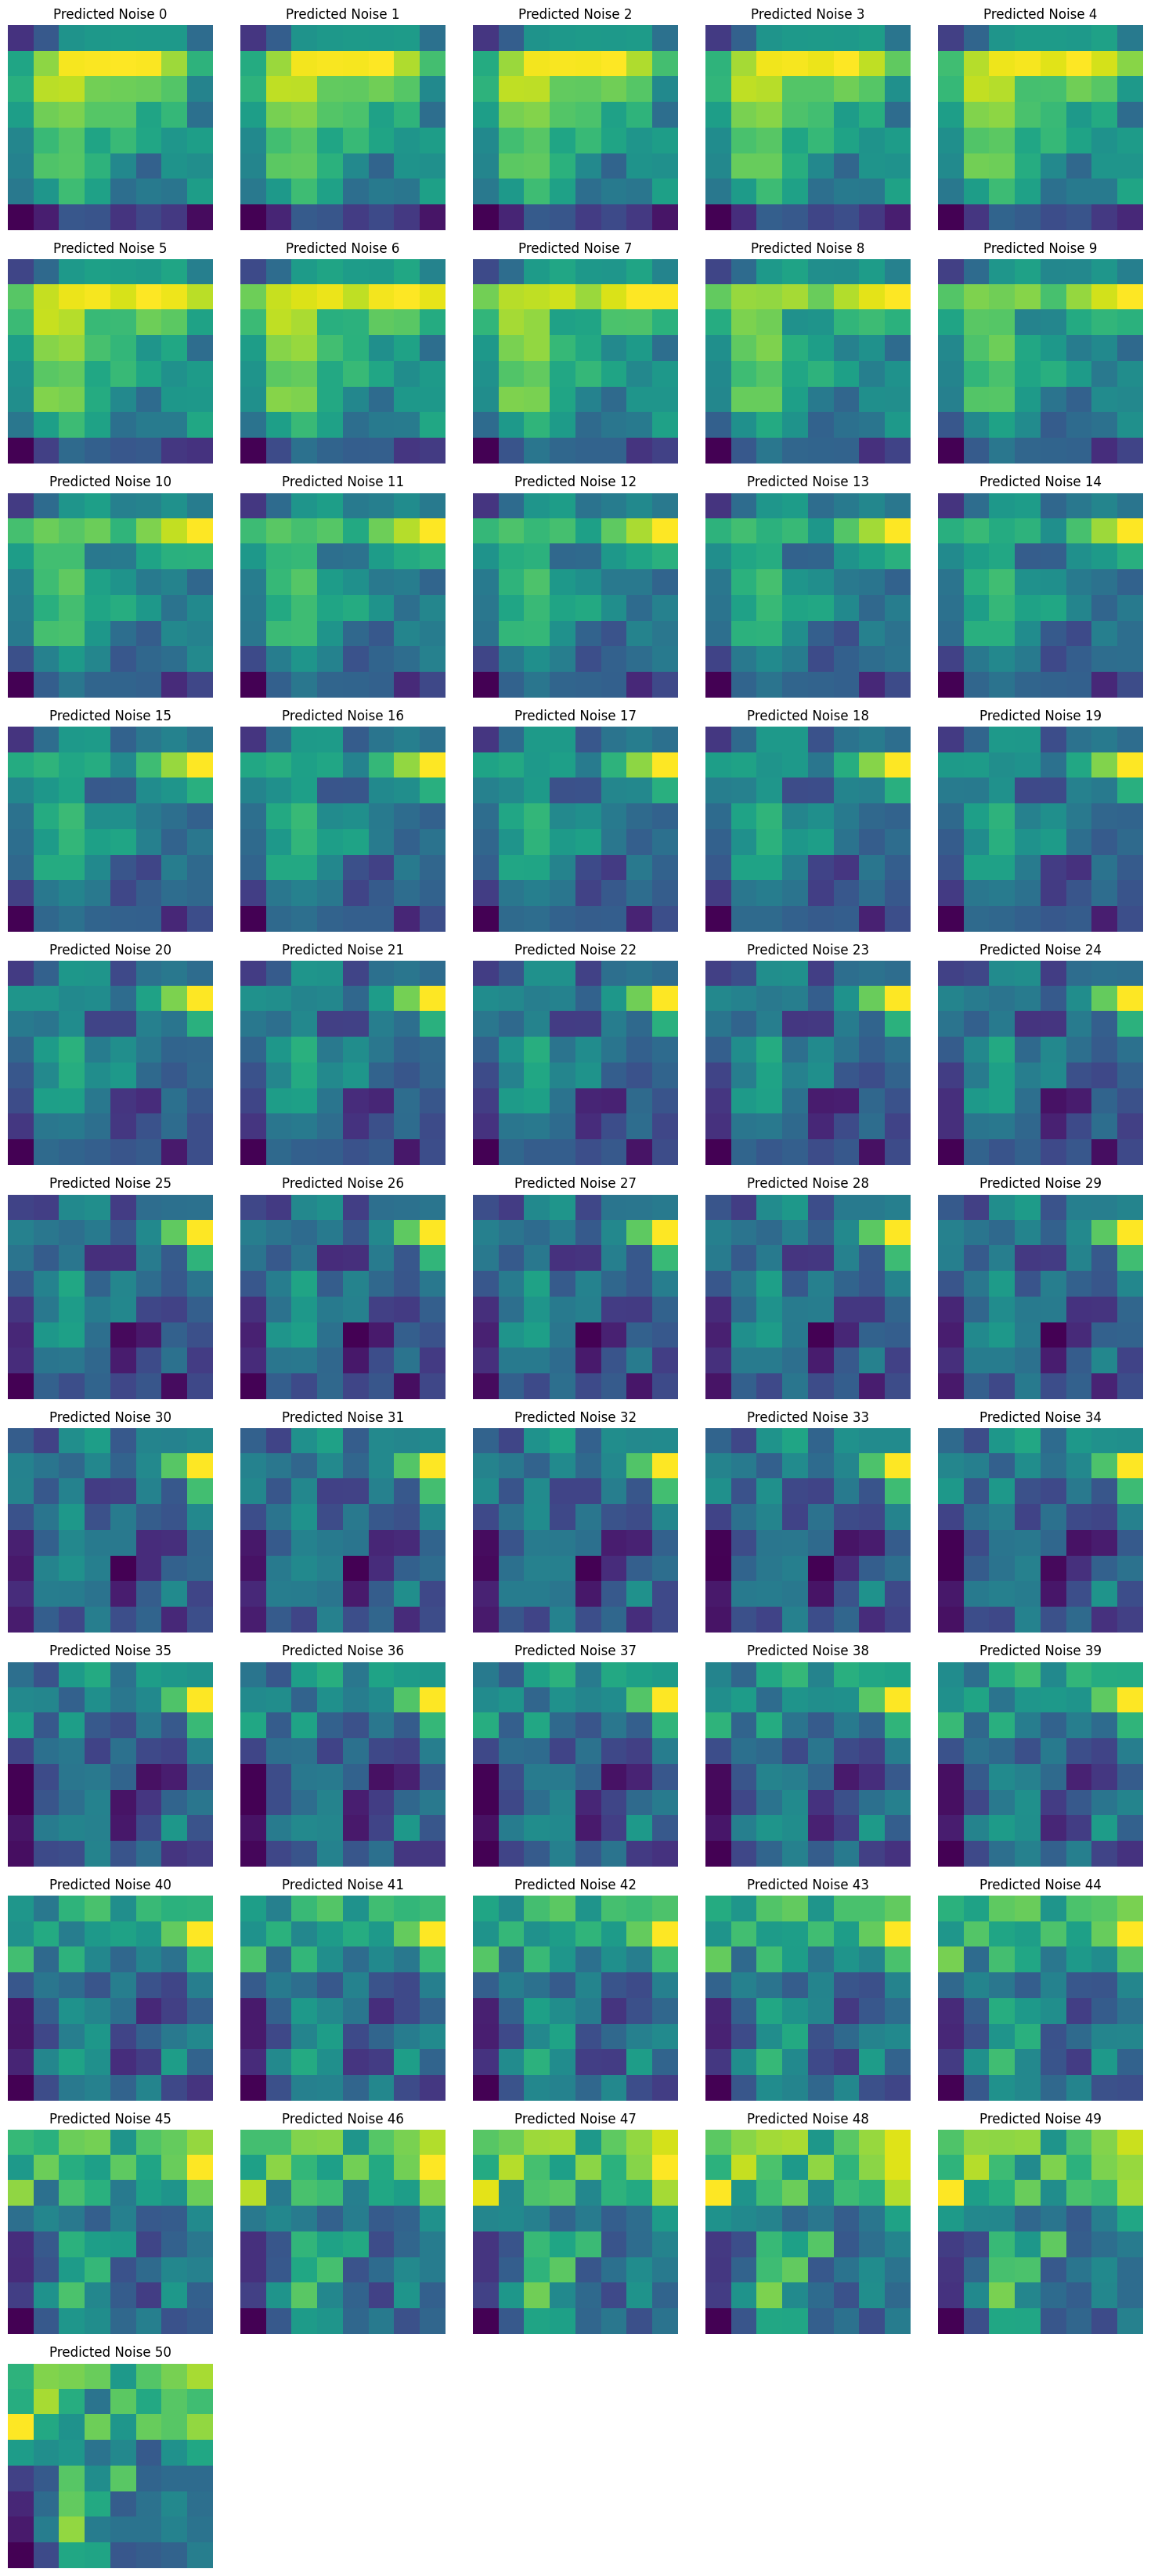

In [10]:
# Plot first channel images from each tensor in outputs[-1] in a grid
num_tensors = len(outputs[-1])
cols = 5
rows = (num_tensors + cols - 1) // cols  # Ceiling division to handle non-multiple of 5
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i, tensor in enumerate(outputs[-1]):
    row = i // cols
    col = i % cols
    # Plot predicted noise
    if rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]
    ax.imshow(tensor[0,0].cpu().numpy())
    ax.set_title(f'Predicted Noise {i}')
    ax.axis('off')

# Turn off any empty subplots
for i in range(num_tensors, rows * cols):
    row = i // cols
    col = i % cols
    if rows == 1:
        axes[col].axis('off')
    else:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


Channel Norms Shape: torch.Size([100, 1280])


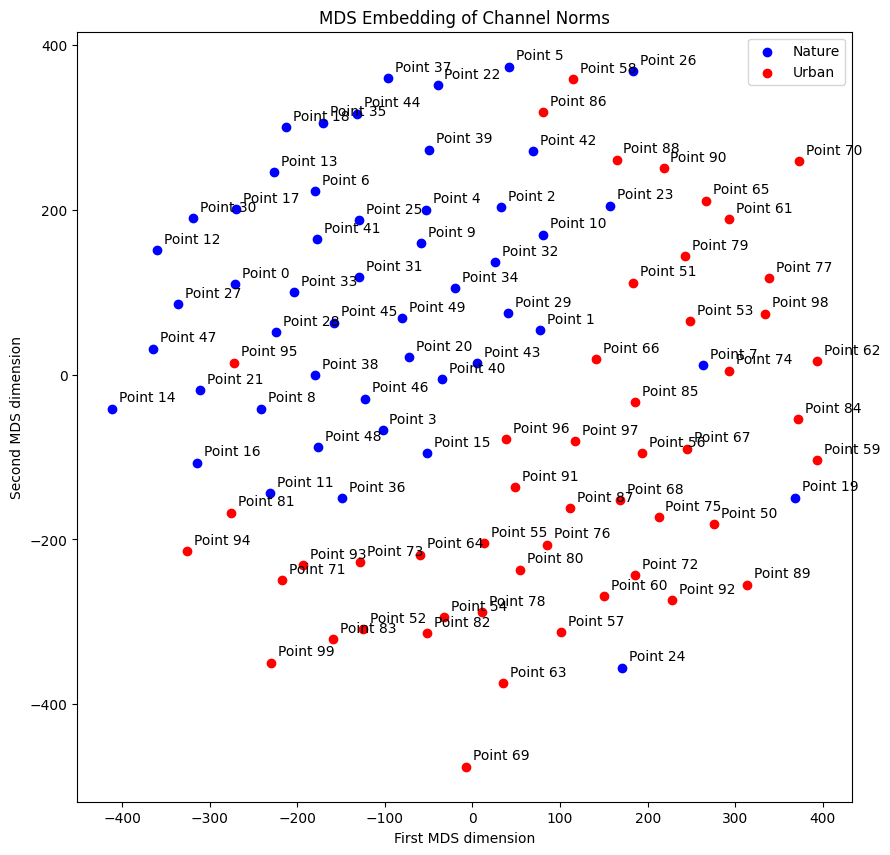

In [23]:
# Calculate L2 norm for each channel in outputs[-1]
# Each tensor in outputs[-1] has shape [20, 1280, 8, 8]
# We want to get L2 norm for each channel resulting in shape [20, 1280]
# Calculate L2 norm across spatial dimensions (H,W) for each channel and each batch item
channel_norms = torch.norm(torch.tensor(outputs[-1]), p=2, dim=(2,3))  # Results in [20, 1280]
print("Channel Norms Shape:", channel_norms.shape)

# Convert channel norms to numpy array for MDS
channel_norms_np = channel_norms.cpu().numpy()

# Calculate pairwise distances between the 20 points in 1280-dimensional space
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

# Create MDS object and fit the data
mds = MDS(n_components=2, random_state=42)
mds_coords = mds.fit_transform(channel_norms_np)

separations = [50, 100]
colors = ['blue', 'red']
labels = ['Nature', 'Urban']

# Plot the MDS embedding
plt.figure(figsize=(10, 10))

for i, (separation, color, label) in enumerate(zip(separations, colors, labels)):
    plt.scatter(mds_coords[0 if i == 0 else separations[i-1]:separation, 0], mds_coords[0 if i == 0 else separations[i-1]:separation, 1], c=color, label=label)

plt.title('MDS Embedding of Channel Norms')
plt.xlabel('First MDS dimension')
plt.ylabel('Second MDS dimension')
plt.legend()

# Add point labels
for i, (x, y) in enumerate(mds_coords):
    plt.annotate(f'Point {i}', (x, y), xytext=(5, 5), textcoords='offset points')

plt.show()


Channel Norms Shape: torch.Size([100, 1280])


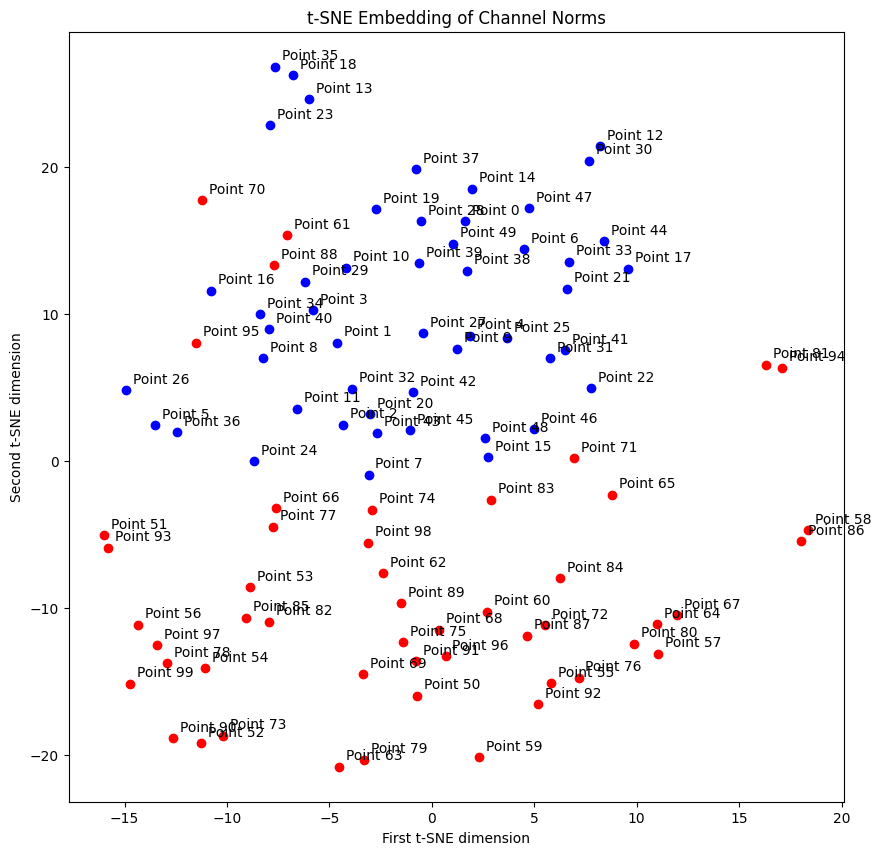

In [29]:
# Calculate L2 norm for each channel in outputs[-1]
# Each tensor in outputs[-1] has shape [20, 1280, 8, 8]
# We want to get L2 norm for each channel resulting in shape [20, 1280]
# Calculate L2 norm across spatial dimensions (H,W) for each channel and each batch item
channel_norms = torch.norm(torch.tensor(outputs[-1]), p=2, dim=(2,3))  # Results in [20, 1280]
print("Channel Norms Shape:", channel_norms.shape)

# Convert channel norms to numpy array for MDS
channel_norms_np = channel_norms.cpu().numpy()

# Calculate pairwise distances between the 20 points in 1280-dimensional space
from sklearn.manifold import TSNE

# Create t-SNE object and fit the data
# Set perplexity to a value less than n_samples (20 in this case)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_coords = tsne.fit_transform(channel_norms_np)

separations = [50, 100]
colors = ['blue', 'red']
labels = ['Nature', 'Urban']

# Plot the MDS embedding
plt.figure(figsize=(10, 10))

for i, (separation, color, label) in enumerate(zip(separations, colors, labels)):
    plt.scatter(tsne_coords[0 if i == 0 else separations[i-1]:separation, 0], tsne_coords[0 if i == 0 else separations[i-1]:separation, 1], c=color, label=label)

plt.title('t-SNE Embedding of Channel Norms')
plt.xlabel('First t-SNE dimension')
plt.ylabel('Second t-SNE dimension')

# Add point labels
for i, (x, y) in enumerate(tsne_coords):
    plt.annotate(f'Point {i}', (x, y), xytext=(5, 5), textcoords='offset points')

plt.show()


In [30]:
# Save latents if save_flag is True
save_flag = False  # Can be changed to False when saving is not needed
if save_flag:
    save_path = "saved_latents.pt"
    torch.save(all_latents, save_path)
    print(f"Saved latents to {save_path}")

# Load saved latents when needed
load_flag = True  # Set to True when loading is needed
if load_flag:
    load_path = "saved_latents.pt"
    if os.path.exists(load_path):
        loaded_latents = torch.load(load_path)
        print(f"Loaded latents from {load_path}")
        print("Loaded Latents Shape:", loaded_latents.shape)
    else:
        print(f"No saved latents found at {load_path}")


Saved latents to saved_latents.pt
Loaded latents from saved_latents.pt
Loaded Latents Shape: torch.Size([1300, 4, 4, 64, 64])


/tmp/ipykernel_54396/950802498.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_latents = torch.load(load_path)


In [31]:
# Get only the last timestep (-1) for each image
last_timestep_latents = loaded_latents[-1]
print("Shape of last timestep latents:", last_timestep_latents.shape)

torch.Size([1300, 4, 4, 64, 64])

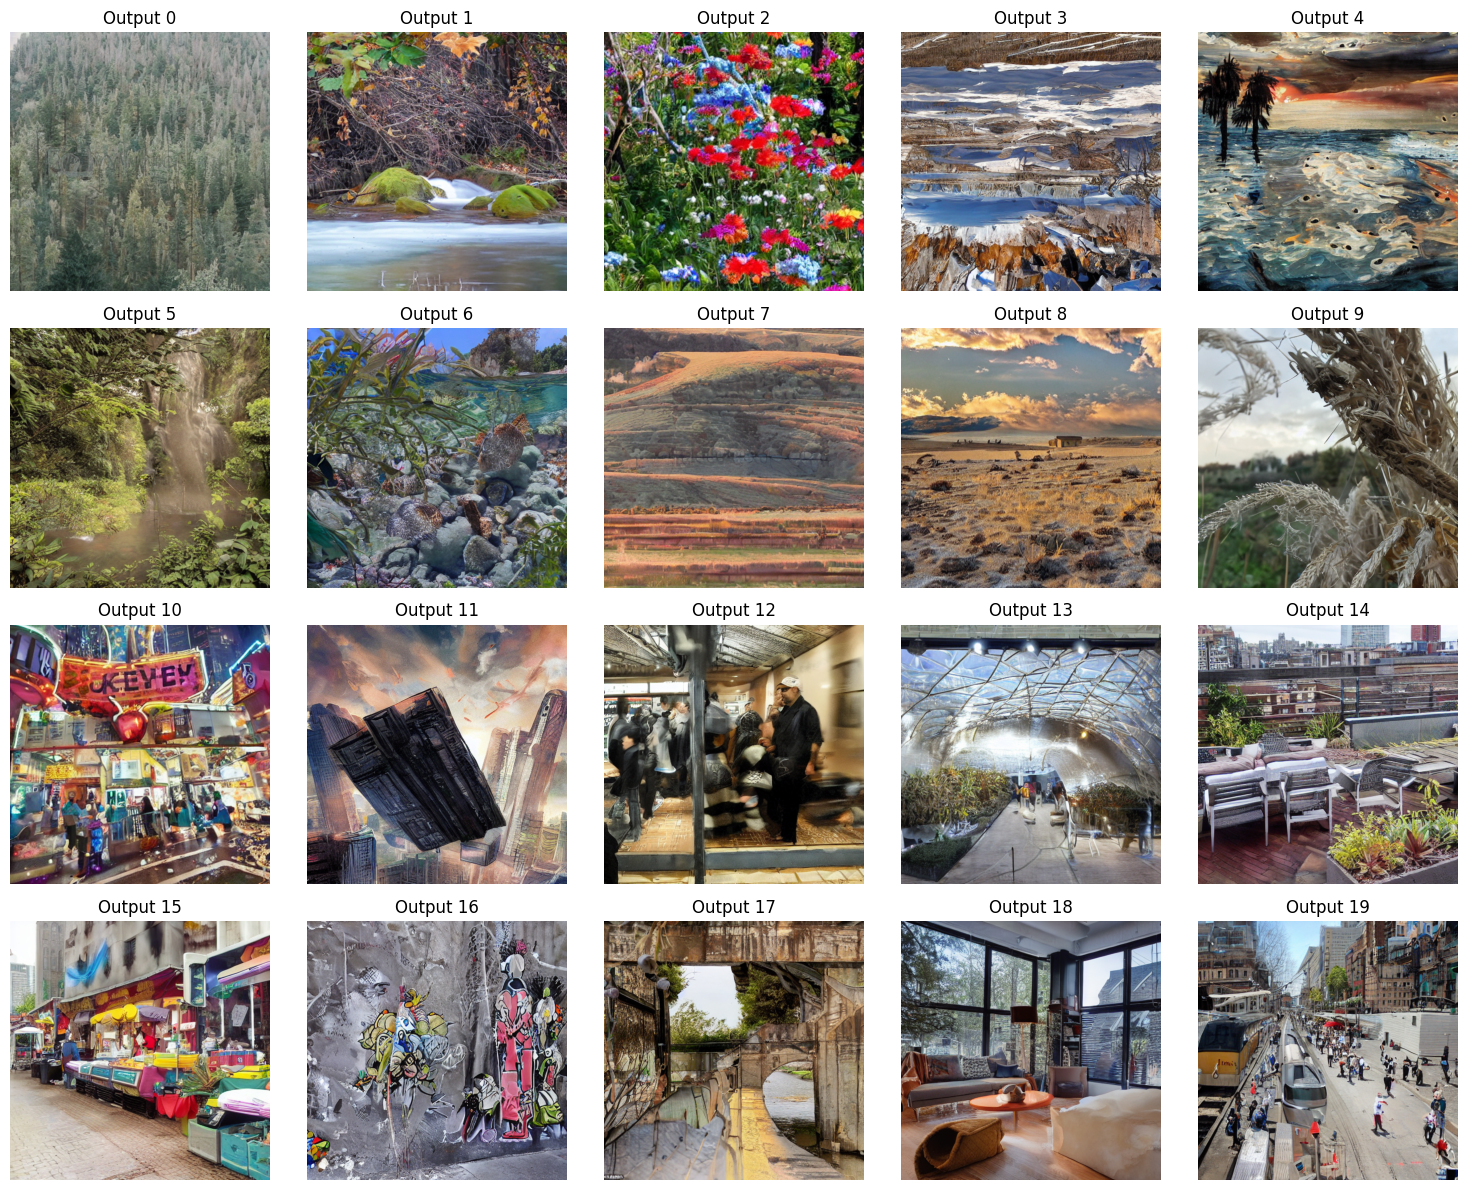

In [9]:
# Get all final outputs
final_outputs = loaded_latents[-1]

# Calculate grid dimensions
num_images = len(final_outputs)
cols = 5
rows = (num_images + cols - 1) // cols  # Ceiling division

# Create a figure to display the images in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
if rows == 1:
    axes = [axes]  # Make single row indexable

# Decode and display each output
with torch.no_grad():
    for i, final_output in enumerate(final_outputs):
        row = i // cols
        col = i % cols
        
        # Decode the output to get the image
        image = vae.decode(torch.from_numpy(np.array([final_output])).to(device) / 0.18215).sample
        
        # Convert the image from [-1, 1] to [0, 1] range
        image = (image / 2 + 0.5).clamp(0, 1)
        
        # Permute and convert to numpy array for visualization
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
        # Display the image
        if rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(f'Output {i}')
        ax.axis('off')

# Turn off any empty subplots
for i in range(num_images, rows * cols):
    row = i // cols
    col = i % cols
    if rows == 1:
        axes[col].axis('off')
    else:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()